# Lets figure out GIS

## Todo

- [ ] Get property boundaries loaded
- [ ] Get planning layers loaded
- [ ] Get heritage overlays loaded
- [ ] Delete earlier notebook

# Scrapping

Here I'm testing different configurations for scrapping.

## Request Times

- Querying NSW Address field
  - Filtering by `lastupdated` field
    - Jan 2023 to Jun 2024, 0h 3m 55s
    - Jan 2020 to Oct 2024, 0h 10m 39s 
    - Jan 2010 to Oct 2024, **4**h **16**m **29**s (`2410766` items)
      - Interestingly the earliest record was dated to `April 2013`
    - Feb 2013 to Apr 2013
      - I checked this to see `April 2013` is really the last period
      - The first 2 months takes **2**m **27**s to run @ `25703` items
    - Jan 1990 to Jan 2010

lastupdate >= DATE '2013-4-01' AND lastupdate < DATE '2013-5-01' 12
2024-09-15 13:37:53 #337: 33603 items @ 1m 8s


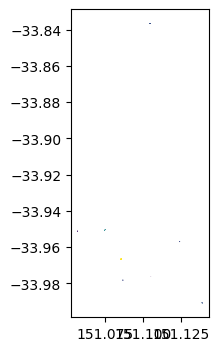

,RID,propid,principaladdresssiteoid,addressstringoid,propertytype,superlot,housenumber,address,principaladdresstype,createdate,startdate,enddate,lastupdate,shapeuuid,changetype,Shape__Length,Shape__Area,geometry
0,118651,1453236,111838,5611383,1,Y,38,38 HILLY STREET MORTLAKE,1,1135036800000,1365118225000,32503680000000,1365118317853,c6504816-229d-3b90-8010-94c050b48712,M,194.517963,2000.751032,"POLYGON ((151.10439 -33.83688, 151.10433 -33.8..."


In [ ]:
from aiohttp import ClientSession
from datetime import datetime
import geopandas as gpd
from IPython.display import clear_output
import math
import matplotlib.pyplot as plt
import time

from lib.gis.defaults import NSW_ADDRESS_PROJECTION, NSW_LOT_PROJECTION
from lib.gis.request import GisPredicate, YearMonth
from lib.gis.gis_reader import GisReader, GisReaderError, GisPredicate

concurrent, print_n, predicate = 12, 1, GisPredicate(YearMonth(2013, 2), YearMonth(2013, 5))

async def read_pages(reader, projection):
    splot = lambda: plt.subplots(1, 1, figsize=(2, 4))

    fig, ax = splot()
    count, items, start_time = 0, 0, time.time()

    def render(chunk, page):
        t = int(time.time() - start_time)
        clear_output(wait=True)
        time_of_day = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        print(chunk.where_clause, concurrent) 
        print(f'{time_of_day} #{count}: {items} items @ {t // 60}m {t % 60}s')
        plt.show()
        if page is not None:
            display(page.iloc[:1])
    
    ym, page = None, None
    async for clause, page in reader.load_projection(projection, predicate):
        page.plot(ax=ax, column='Shape__Area')
        items, count = items + len(page), count + 1
        if not count % print_n:
            render(clause, page)
            fig, ax = splot()
            
    render(clause, page)
    print(f"finished loading GIS'")

try:
    async with ClientSession() as session:
        gis_reader = GisReader.create(session, max_concurrent=concurrent)
        await read_pages(gis_reader, NSW_ADDRESS_PROJECTION)
        # await read_pages(gis_reader, NSW_LOT_PROJECTION)
except GisReaderError as e:
    print(e)

print(predicate.start < predicate.end)